In [102]:
import os
save_dir = "./mmmlu_confidence_output"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [103]:
lang_list = ["EN", "JA_JP"]
curr_language = lang_list[0]

model_list = ["gemini-2.0-flash", "mistral-small-2503"]
model_name = model_list[1]

In [104]:
from mmmlu_preparer.query_formats import (
    get_current_queries,
    InputFormat,
    OutputFormat,
    ShuffleMethod
)

# BASE, JSON, XML
curr_input_format = InputFormat.BASE

# BASE, JSON_FULL, XML_FULL
curr_output_format = OutputFormat.BASE

# DEFAULT, REVERSE, LONGEST_FIRST, SHORTEST_FIRST, MOST_KANA_RATIO, FEWEST_KANA_RATIO
curr_shuffle_method = ShuffleMethod.DEFAULT

input_format_save_name = curr_input_format.value.lower().replace("_", "-")
output_format_save_name = curr_output_format.name.lower().replace("_", "-")
shuffle_method_save_name = curr_shuffle_method.name.lower().replace("_", "-")

language_name = curr_language.lower().replace("_", "-")

save_name = f"{model_name}_{language_name}_{input_format_save_name}_input_{output_format_save_name}_output_{shuffle_method_save_name}_shuffle"
save_name

'mistral-small-2503_en_base_input_base_output_default_shuffle'

In [105]:
from pathlib import Path
import json

iter_list = []

for iter_i in range(10):
    save_path = f"{save_dir}/{save_name}_confidence_{iter_i}.jsonl"
    target_save_path = Path(save_path)
    if not target_save_path.exists():
        break
    with target_save_path.open('r', encoding='utf-8') as file:
        result_dicts = [json.loads(line) for line in file if line.strip()]
    iter_list.append(result_dicts)

In [106]:
from mmmlu_preparer.answer_extract import extract_answer_from_response

iter_answer_list = []
for iter_i in range(len(iter_list)):
    result_dicts = iter_list[iter_i]
    output_text = [result['kwargs']['content'] for result in result_dicts]
    output_answer = []
    none_answer_indice = []
    none_answer_output = []
    for idx, output in enumerate(output_text):
        extracted_answer = extract_answer_from_response(output)
        output_answer.append(extracted_answer)
        if extracted_answer is None:
            none_answer_indice.append(idx)
            none_answer_output.append(output)
            output_answer[-1] = "Other"
            #print(idx)
            # print(f"{idx}:\n{output = }\n")
    iter_answer_list.append(output_answer)
    print(f"{len(none_answer_indice) = }")

len(none_answer_indice) = 0
len(none_answer_indice) = 1
len(none_answer_indice) = 1
len(none_answer_indice) = 1
len(none_answer_indice) = 1
len(none_answer_indice) = 1
len(none_answer_indice) = 1
len(none_answer_indice) = 1
len(none_answer_indice) = 0
len(none_answer_indice) = 0


In [107]:
from collections import Counter
answer_counter_list = list(map(Counter, zip(*iter_answer_list)))

In [108]:
import math
def compute_confidence_entropy(counter, option_num=5):
    # option_num = (ABCD + others)
    total_sample_num = sum(vals for vals in counter.values())
    entropy = 0
    for option, counting in counter.items():
        option_freq = counting / total_sample_num
        entropy += -option_freq * math.log(option_freq)

    max_entropy = math.log(option_num)
    return 1 - entropy / max_entropy


def compute_highest_prob(counter):
    total_sample_num = sum(vals for vals in counter.values())
    highest_sample_counting = max(counter.values())
    return highest_sample_counting / total_sample_num

In [109]:
import mmmlu_preparer
from mmmlu_preparer.read_mmmlu_dataset import (
    TARGET_SUBTASKS,
    MMMLULanguage,
    create_mmmlu_dataset,
    sample_first_n_data_from_subtask
)

lang_list = ["EN", "JA_JP"]
curr_language = lang_list[0]
dataset_language_enum = MMMLULanguage[curr_language]

mmmlu_ds = create_mmmlu_dataset(dataset_language_enum)
chosen_subtasks = TARGET_SUBTASKS
mmmlu_subset = sample_first_n_data_from_subtask(mmmlu_ds, chosen_subtasks)

In [110]:
import pandas as pd
mmmlu_subset_df = mmmlu_subset.to_pandas()
mmmlu_subset_df = mmmlu_subset_df.rename({"Subject": "Subtask"}, axis=1)

In [111]:
mmmlu_subset_df['Entropy confidence'] = [compute_confidence_entropy(curr_counter) for curr_counter in answer_counter_list]
mmmlu_subset_df['Max prob confidence'] = [compute_highest_prob(curr_counter) for curr_counter in answer_counter_list]

In [112]:
mmmlu_subset_df['Max prob confidence'].unique()

array([1. , 0.7, 0.6, 0.5, 0.8, 0.9, 0.4, 0.3])

In [113]:
confidence_csv = mmmlu_subset_df[['Question id in subtask', 'Question', 'Subtask', 'Entropy confidence', 'Max prob confidence']]
confidence_csv.to_csv(f"{model_name}_confidence.csv", index=False)

In [114]:
import pandas as pd
from pathlib import Path
# From analysis
target_model_name = model_name
test_df = pd.read_csv(f'{target_model_name}_merged_results.csv', engine='c')

In [115]:
confidence_csv_path = Path(f'{target_model_name}_confidence.csv')
if confidence_csv_path.exists():
    confidence_df = pd.read_csv(confidence_csv_path, engine='c')

In [116]:
import ast

def shuffle_map_type_conversion(shuffle_map):
    """Convert shuffled map string to python dictionary"""
    if isinstance(shuffle_map, str):
        return ast.literal_eval(shuffle_map)
    return shuffle_map

test_df['Original to shuffled'] = test_df['Original to shuffled'].apply(shuffle_map_type_conversion)
test_df['Shuffled to Original']  = test_df['Original to shuffled'].apply(lambda x: {val:key for key, val in x.items()})


In [117]:
def map_answer(row):
    """Convert model's answer to the id in the default order"""
    response_ansewr = row['Response answer']
    shuffled_to_original = row['Shuffled to Original']
    if response_ansewr in shuffled_to_original:
        return shuffled_to_original[response_ansewr]
    return response_ansewr # nan

test_df['Response answer id in default'] = test_df.apply(map_answer, axis=1)

In [118]:
import pandas as pd
import numpy as np

# By ChatGPT
english_df = test_df[(test_df['Language'] == 'en')].reset_index()
counts = (
    english_df.groupby(['Subtask', 'Question id in subtask'])['Response answer id in default']
    .value_counts()
    .rename('count')
    .reset_index()
)
counts['freq'] = counts.groupby(['Subtask', 'Question id in subtask'])['count'].transform(lambda x: x / x.sum())

option_num = 5 # ABCD + others
counts['entropy_component'] = (-counts['freq'] * np.log(counts['freq'])) / np.log(option_num)

entropy_df = counts.groupby(['Subtask', 'Question id in subtask'])['entropy_component'].sum().reset_index()
entropy_df = entropy_df.rename(columns={'entropy_component': 'entropy'})


In [119]:
lang_question_entropy_confidence = pd.merge(
    entropy_df,
    confidence_df,
    how='left',
    on=['Subtask', 'Question id in subtask']
)
lang_question_entropy_confidence[['entropy', 'Entropy confidence', 'Max prob confidence']].head(5)

,entropy,Entropy confidence,Max prob confidence
0,0.000000,1.000000,1.0
1,0.605376,0.501802,0.7
2,0.559361,1.000000,1.0
3,0.588440,0.581834,0.6
4,0.483064,1.000000,1.0


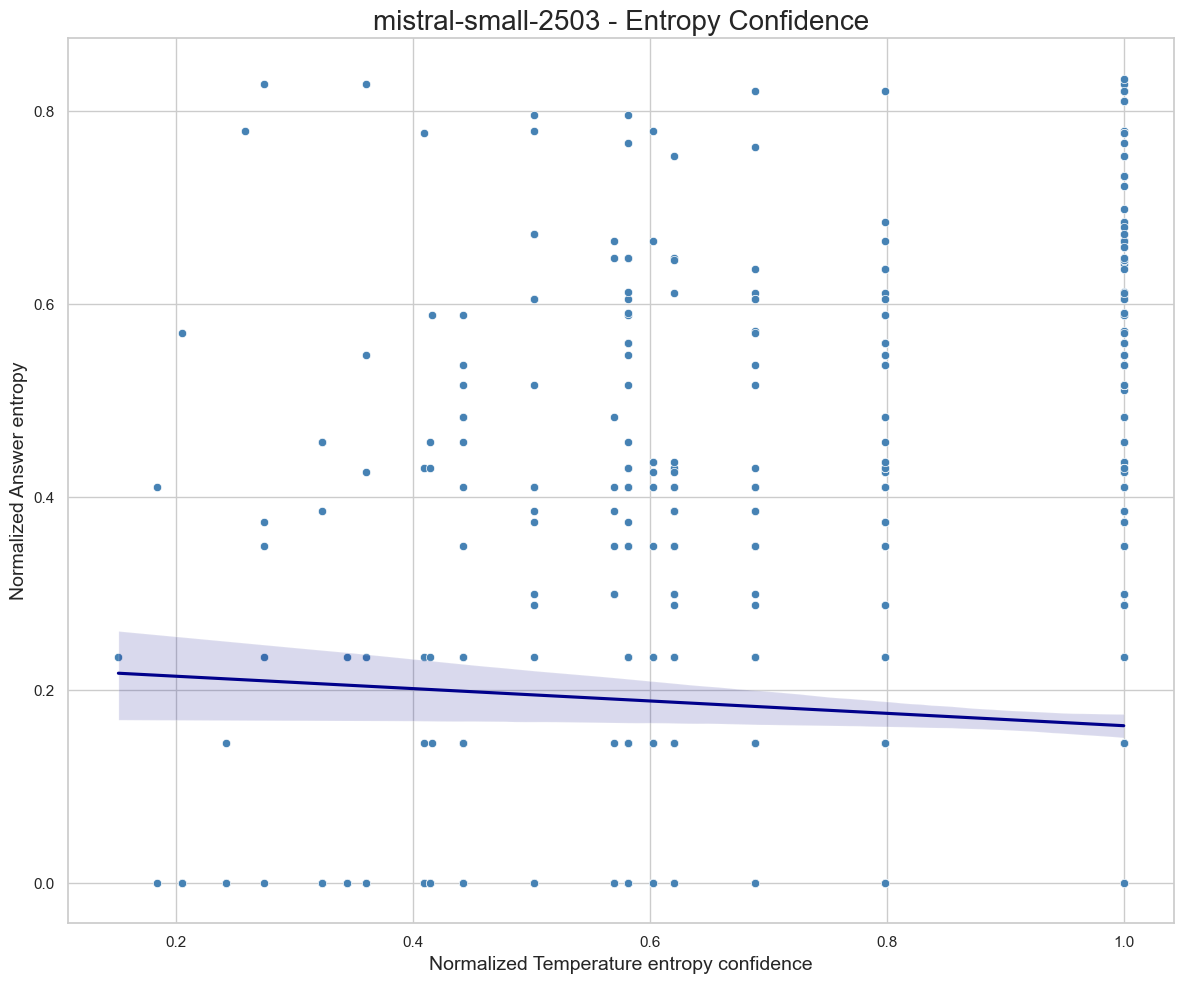

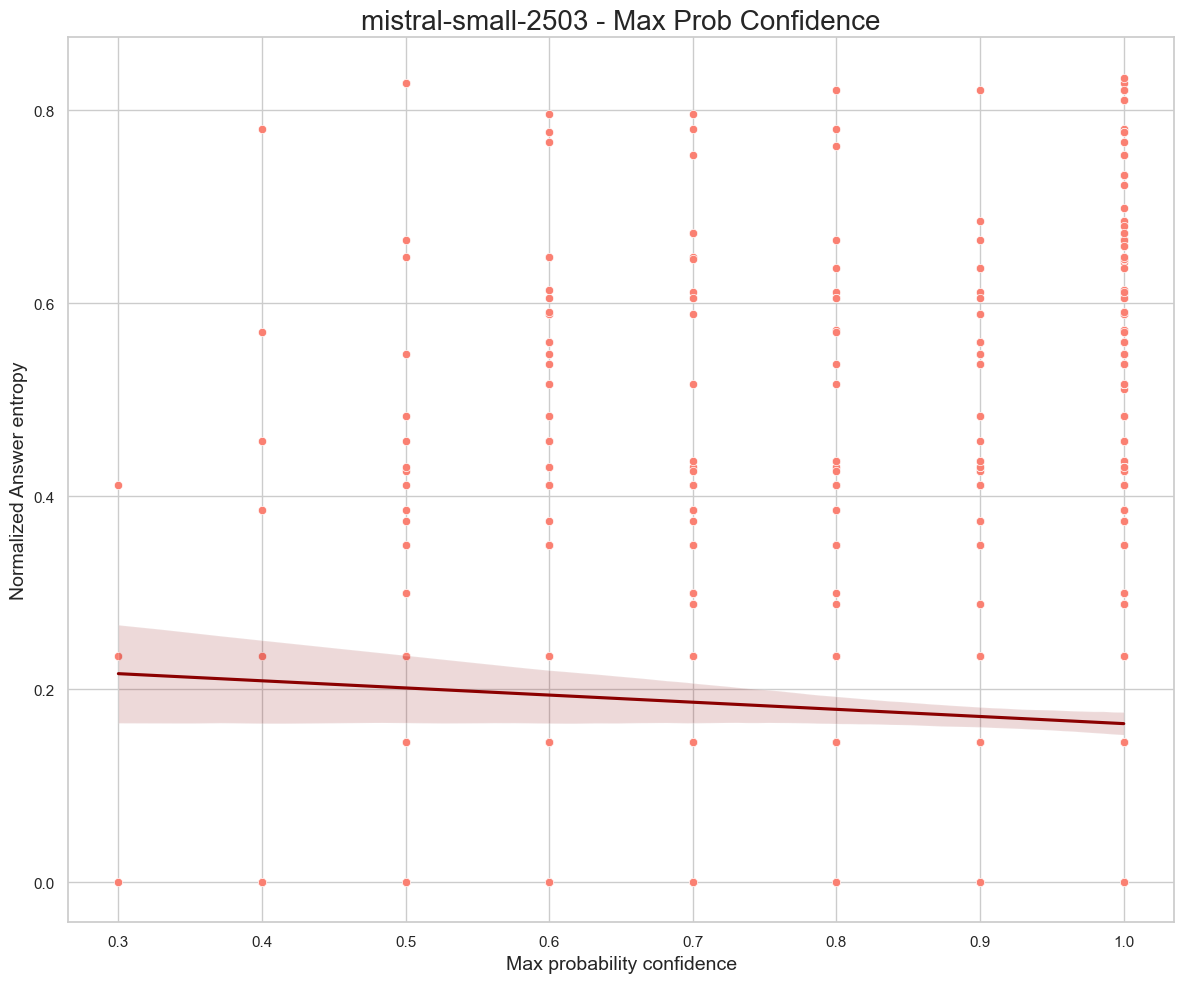

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

# 設定 seaborn 風格
sns.set_theme(style="whitegrid")

# 第一張圖：Entropy confidence vs Entropy
plt.figure(figsize=(12, 10))
ax = sns.scatterplot(data=lang_question_entropy_confidence, x='Entropy confidence', y='entropy', color='steelblue')
sns.regplot(data=lang_question_entropy_confidence, x='Entropy confidence', y='entropy', scatter=False, color='darkblue')
ax.set_ylabel("Normalized Answer entropy", fontsize=14)
ax.set_xlabel("Normalized Temperature entropy confidence", fontsize=14)
plt.title(f'{target_model_name} - Entropy Confidence', fontsize=20)
plt.tight_layout()
plt.savefig(f"{target_model_name}_Entropy_Confidence.svg", format='svg')
plt.show()

# 第二張圖：Max Prob confidence vs Entropy
plt.figure(figsize=(12, 10))
ax = sns.scatterplot(data=lang_question_entropy_confidence, x='Max prob confidence', y='entropy', color='salmon')
sns.regplot(data=lang_question_entropy_confidence, x='Max prob confidence', y='entropy', scatter=False, color='darkred')
ax.set_ylabel("Normalized Answer entropy", fontsize=14)
ax.set_xlabel("Max probability confidence", fontsize=14)
plt.title(f'{target_model_name} - Max Prob Confidence', fontsize=20)
plt.tight_layout()
plt.savefig(f"./{target_model_name}_Max_Prob_Confidence.svg", format='svg')
plt.show()

